<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span><ul class="toc-item"><li><span><a href="#Libraires-et-dataset" data-toc-modified-id="Libraires-et-dataset-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Libraires et dataset</a></span></li><li><span><a href="#Création-d'une-baseline" data-toc-modified-id="Création-d'une-baseline-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Création d'une baseline</a></span></li></ul></li><li><span><a href="#Diversification-des-modèles" data-toc-modified-id="Diversification-des-modèles-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Diversification des modèles</a></span><ul class="toc-item"><li><span><a href="#Fonction-d'évaluation" data-toc-modified-id="Fonction-d'évaluation-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Fonction d'évaluation</a></span></li><li><span><a href="#Transformation-logarithmique" data-toc-modified-id="Transformation-logarithmique-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Transformation logarithmique</a></span></li><li><span><a href="#Validation-croisée" data-toc-modified-id="Validation-croisée-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Validation croisée</a></span></li></ul></li><li><span><a href="#Amélioration-du-prétraitement" data-toc-modified-id="Amélioration-du-prétraitement-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Amélioration du prétraitement</a></span><ul class="toc-item"><li><span><a href="#Imputations-et-encodages" data-toc-modified-id="Imputations-et-encodages-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Imputations et encodages</a></span></li><li><span><a href="#Feature-importance" data-toc-modified-id="Feature-importance-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Feature importance</a></span></li></ul></li><li><span><a href="#Construction-du-modèle-final" data-toc-modified-id="Construction-du-modèle-final-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Construction du modèle final</a></span><ul class="toc-item"><li><span><a href="#Sélection-des-features" data-toc-modified-id="Sélection-des-features-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Sélection des features</a></span></li><li><span><a href="#Recherche-des-hyperparamètres" data-toc-modified-id="Recherche-des-hyperparamètres-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Recherche des hyperparamètres</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></li></ul></div>

# Introduction

Présenter les différentes parties de ce notebook.

Faire allusion à l'autre notebook où les données ont été préparées et analysées.

On s'intéresse ici à la prédiction de la consommation énergétique : la cible est la variable `SiteEnergyUseWN(kBtu)`.

Présenter les différentes parties de cette section.

## Libraires et dataset

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, TransformedTargetRegressor

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, TargetEncoder, FunctionTransformer

from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import time
import re
import shap

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import RobustScaler
from category_encoders import TargetEncoder as MeanEncoder
from sklearn.model_selection import cross_val_score

In [29]:
data = pd.read_csv("csv/filtered_data.csv")

df = data.drop("TotalGHGEmissions", axis = 1)
target = "SiteEnergyUseWN(kBtu)"

In [30]:
def display_dimensions(df) :
    print(f"Dimensions du dataset :")
    print("  -", df.shape[0], "lignes")
    print("  -", df.shape[1], "colonnes")
    
display_dimensions(df)

Dimensions du dataset :
  - 1621 lignes
  - 26 colonnes


## Création d'une baseline

On commence par séparer la variable cible `SiteEnergyUseWN(kBtu)` du reste, puis à séparer les données en un jeu d'entraînement et un jeu de test.

In [31]:
X = df.drop(target, axis = 1)
y = df[target].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

On applique deux traitements différents suivant si les variables sont numériques ou catégorielles :
- Variables numériques : on impute les valeurs manquantes par la médiane.
- Variables catégorielles : on impute les valeurs manquantes par le mode (valeur la plus fréquente) puis on applique un encodage ordinal.

In [32]:
# Séparation des variables numériques et catégorielles
numerical_features = X_train.select_dtypes(include = ["number"]).columns.tolist()
categorical_features = X_train.select_dtypes(include = ["object"]).columns.tolist()

# Transformateur numérique
numerical_transformer = make_pipeline(SimpleImputer(strategy = "median"))

# Transformateur catégoriel
categorical_transformer = make_pipeline(SimpleImputer(strategy = "most_frequent"),
                                        OrdinalEncoder(handle_unknown = "use_encoded_value", unknown_value = -1),
                                        RobustScaler())

On associe ce prétraitement à un algorithme de régression linéaire pour former notre modèle basique.<br>
Cet algorithme suppose l'existence d'une relation linéaire entre les caractéristiques d'entrée et la variable cible.<br>
C'est simple et rapide, mais peut manquer de complexité.

In [33]:
# Transformateur global
preprocessor_1 = ColumnTransformer(transformers = [
    ("numerical", numerical_transformer, numerical_features),
    ("categorical", categorical_transformer, categorical_features)
])

# Association du modèle au transformateur
pipeline = make_pipeline(preprocessor_1, LinearRegression())

On entraîne le modèle sur le jeu d'entraînement, puis l'utilise pour effectuer des prédictions sur le jeu de test.

In [34]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['CouncilDistrictCode',
                                                   'Latitude', 'Longitude',
                                                   'YearBuilt',
                                                   'NumberofBuildings',
                                                   'NumberofFloors',
                                                   'PropertyGFATotal',
                                                   'PropertyGFAParking',
                                                   'PropertyGFABuilding(s)',
                                                   'LargestPropertyUseTypeGFA',
                                                   'SecondLarg...
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1)),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['BuildingType',
                                                   'PrimaryPropertyType',
                                                   'Neighborhood',
                                                   'ListOfAllPropertyUseTypes',
                                                   'LargestPropertyUseType',
                                                   'SecondLargestPropertyUseType',
                                                   'ThirdLargestPropertyUseType',
                                                   'YearsENERGYSTARCertified',
                                                   'ComplianceStatus'])])),
                ('linearregression', LinearRegression())])

In [35]:
y_pred = pipeline.predict(X_test)

Afin d'évaluer la qualité des prédictions, et on les compare aux résultats réels grâce aux trois métriques suivantes :
- **Root Mean Squared Error (RMSE)** : racine carrée de la moyenne des carrés des écarts entre les prédictions et les valeurs réelles.
- **Mean Absolute Error (MAE)** : moyenne des valeurs absolues des écarts entre les prédictions et les valeurs réelles.
- **Coefficient R²** : proportion de la variance dans la variable à prédire qui est expliquée par le modèle.

In [36]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("--- Model basique ---")
print(f"RMSE : {rmse:.2f}")
print(f"MAE : {mae:.2f}")
print(f"R² : {r2:.2f}")

--- Model basique ---
RMSE : 24893329.38
MAE : 6628328.55
R² : 0.39


**Commentaires :**

L'unité de la variable cible (kBtu) n'étant pas très parlante, le coefficient R² est le plus indiqué pour se donner une idée de la performance du modèle.<br>
Un score de 0.39 est plutôt bas, mais cela servira de point de départ qu'il s'agit désormais d'améliorer.

# Diversification des modèles

Introduisons de nouveaux algorithmes pour remplacer la régression linéaire.
- **Random Forest :** modèle ensembliste qui utilise plusieurs arbres de décision et agrège les résultats.
- **Gradient Boosting :** modèle ensembliste qui construit des arbres de décision successifs, corrigeant les erreurs des arbres précédents.
- **XGBoost :** mise en oeuvre optimisée du gradient boosting.
- **LightGBM :** version plus rapide des algorithmes de boosting basée sur une division de feuilles.
- **Elastic Net :** modèle de régression linéaire avec régularisation (combine lasso et ridge).
- **Support Vector Regression (SVR) :** modèle qui tente de trouver une fonction ayant la plus petite marge d'erreur possible tout en restant à une distance tolérable de chaque point de données.

In [37]:
models = {
    "Linear Regression" : LinearRegression(),
    "Gradient Boost" : GradientBoostingRegressor(),
    "Random Forest" : RandomForestRegressor(),
    "SVR" : SVR(),
    "Elastic Net" : ElasticNet(),
    "XGBoost": XGBRegressor(),
    "LightGBM": LGBMRegressor(verbosity = 0)
}

## Fonction d'évaluation

On propose ici une fonction d'évaluation qu'on pourra appliquer sur chaque modèle.<br>
Elle prend en entrée un modèle, un pipeline de prétraitement et les jeux de données d'entraînement et de test.<br>
Elle applique le modèle et retourne les trois métriques (RMSE, MAE et R²) ainsi que les temps d'entraînement et de prédiction.<br>
Elle calcule aussi le R² sur le jeu d'entraînement, ce qui permet de détecter un overfitting éventuel.

In [38]:
def evaluate(model_name, pipeline, X_test, y_test, X_train, y_train) :
    
    start_training_time = time.time()
    pipeline.fit(X_train, y_train)
    training_time = time.time() - start_training_time

    start_prediction_time = time.time()
    y_pred = pipeline.predict(X_test)
    prediction_time = time.time() - start_prediction_time
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    y_pred_train = pipeline.predict(X_train)
    r2_train = r2_score(y_train, y_pred_train)
    
    result = {
        "Model": model_name,
        "RMSE": round(rmse),
        "MAE": round(mae),
        "R2": round(r2, 3),
        "Training": str(round(training_time * 1000)) + " ms",
        "Prediction": str(round(prediction_time * 1000)) + " ms",
        "R2_Train": round(r2_train, 3),
    }
    
    return result

In [39]:
results = []
    
X = df.drop(columns = [target])
y = df[target].copy()
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
    
for model_name, model in models.items() :
    pipeline = make_pipeline(preprocessor_1, model)
    results.append(evaluate(model_name, pipeline, X_test, y_test, X_train, y_train))

pd.DataFrame(results).set_index("Model")

,RMSE,MAE,R2,Training,Prediction,R2_Train
Model,,,,,,
Linear Regression,24893329,6628329,0.394,17 ms,4 ms,0.684
Gradient Boost,24053156,4793420,0.434,974 ms,4 ms,0.975
Random Forest,24872111,4714765,0.395,3697 ms,12 ms,0.968
SVR,32679364,8007294,-0.044,76 ms,33 ms,-0.073
Elastic Net,24761618,6292414,0.400,56 ms,5 ms,0.669
XGBoost,24992860,4939869,0.389,156 ms,6 ms,1.000
LightGBM,26374403,5419266,0.320,158 ms,8 ms,0.914


**Commentaires :**
- Aucun modèle ne semble faire bien mieux que la régression linéaire pour l'instant.
- La SVR ne semble pas parvenir à converger vers une solution satisfaisante.

## Transformation logarithmique

Nous avions vu dans l'analyse exploratoire qu'il était peut-être préférable d'appliquer une transformation logarithmique à la variable cible ainsi qu'aux diverses variables de superficie. Ajoutons ces transformations dans le prétraitement et regardons si cela améliore les performances.

Ci-dessous, la fonction `evaluate_all` applique de façon optionnelle (argument `log_target`) une transformation logarithmique sur la cible, puis appelle la fonction d'évaluation sur chaque modèle et compile les résultats.

In [40]:
def evaluate_all(models, preprocessor, df, target, log_target = False) :
    
    results = []
    
    X = df.drop(target, axis = 1)
    y = df[target].copy()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
    
    for model_name, model in models.items() :
        
        if log_target :
            model = TransformedTargetRegressor(
                regressor = model,
                transformer = FunctionTransformer(func = np.log1p, inverse_func = np.expm1),
            )
        
        pipeline = make_pipeline(preprocessor, model)
        results.append(evaluate(model_name, pipeline, X_test, y_test, X_train, y_train))

    return pd.DataFrame(results).set_index("Model")

In [41]:
evaluate_all(models, preprocessor_1, df, target, log_target = True)

,RMSE,MAE,R2,Training,Prediction,R2_Train
Model,,,,,,
Linear Regression,141905253,14080816,-18.694,17 ms,6 ms,-81.612
Gradient Boost,24869311,4591126,0.395,992 ms,4 ms,0.906
Random Forest,26318577,4841191,0.323,3363 ms,17 ms,0.938
SVR,29291662,5514470,0.161,71 ms,30 ms,0.582
Elastic Net,361656509,27194327,-126.919,22 ms,4 ms,-172.217
XGBoost,28609122,4977284,0.200,131 ms,7 ms,0.999
LightGBM,26709334,4782197,0.302,74 ms,7 ms,0.949


L'analyse exploratoire que avait révélé que les variables de superficie étaient les plus corrélées aux cibles.<br>
Et nous leur avions également appliqué une transformation logarithmique : essayons de faire de même en créant un nouveau préprocesseur.

In [42]:
log_features = ["PropertyGFATotal", "PropertyGFAParking", "PropertyGFABuilding(s)", "LargestPropertyUseTypeGFA",
                "SecondLargestPropertyUseTypeGFA", "ThirdLargestPropertyUseTypeGFA"]

log_transformer = make_pipeline(FunctionTransformer(np.log1p), SimpleImputer(strategy = "mean"))

other_numerical_features = ["CouncilDistrictCode", "Latitude", "Longitude", "YearBuilt", "ENERGYSTARScore",
                            "NumberofBuildings", "NumberofFloors", "ElectricityRatio", "GasRatio", "SteamRatio"]

In [43]:
preprocessor_2 = ColumnTransformer(transformers = [
    ("log_transformer", log_transformer, log_features),
    ("median_imputer", numerical_transformer, other_numerical_features),
    ("categorical_transformer", categorical_transformer, categorical_features)
])

In [44]:
evaluate_all(models, preprocessor_2, df, target)

,RMSE,MAE,R2,Training,Prediction,R2_Train
Model,,,,,,
Linear Regression,28860478,8465743,0.185,22 ms,5 ms,0.450
Gradient Boost,23600666,4739824,0.455,990 ms,6 ms,0.975
Random Forest,24724523,4719341,0.402,3795 ms,12 ms,0.970
SVR,32679401,8007347,-0.044,69 ms,32 ms,-0.073
Elastic Net,28856136,7560675,0.186,16 ms,8 ms,0.414
XGBoost,26122206,5108307,0.333,123 ms,7 ms,1.000
LightGBM,26410071,5401249,0.318,77 ms,8 ms,0.914


**Commentaires :**
- Par rapport au score initial, les résultat de la Random Forest et du Gradient Boost sont très proches.
- Cette fois la SVR converge, mais le résultat n'est pas bon.
- Les deux modèles linéaires ne convergent plus, sans doute car les variables les plus pertinentes n'ont plus une relation linéaire à la cible maintenant que celle-ci a été passée au logarithme.

In [46]:
evaluate_all(models, preprocessor_2, df, target, log_target = True)

,RMSE,MAE,R2,Training,Prediction,R2_Train
Model,,,,,,
Linear Regression,28089637,5239123,0.228,20 ms,6 ms,0.787
Gradient Boost,23996271,4524621,0.437,939 ms,6 ms,0.903
Random Forest,26421811,4857786,0.317,3408 ms,14 ms,0.943
SVR,32625236,7955895,-0.041,69 ms,30 ms,-0.065
Elastic Net,32131237,7266753,-0.010,15 ms,5 ms,-0.075
XGBoost,26606978,4918684,0.308,122 ms,8 ms,0.999
LightGBM,26649251,4856493,0.305,75 ms,8 ms,0.946


**Commentaires :**
- On retrouve les résultats initiaux, ce qui semble indiquer que les variables de superficie sont celles qui ont le plus d'impact.
- Les deux modèles linéaires ont cependant de moins bonnes performances que sans le logarithme.

En conclusion, il ne semble pas utile d'appliquer la moindre transformation logarithmique pour l'instant.<br>
Néanmoins, maintenant que l'implémentation est faite, on dispose d'un levier qu'on pourra choisir d'actionner ou non dans les tests futurs.

## Validation croisée

Un inconvénient du jeu de donnée est apparu en répétant plusieurs fois les tests précédents : la variance liée à la séparation train/test est plutôt forte.<br>
Certaines parties du jeu de données semblent particulièrement gêner les modèles, là où d'autres conduisent à des résultats plus fiables.<br>
Afin de stabiliser la mesure des performances, on propose ici l'implémentation d'une validation croisée à cinq plis.

In [47]:
def cross_evaluate(model_name, model, preprocessor, X, y) :
    
    pipeline = Pipeline(steps = [
        ("preprocessor", preprocessor),
        (model_name, model)
    ])

    start_time = time.time()
    scores = cross_val_score(pipeline, X, y, cv = 5, scoring = "r2", n_jobs = -1)
    cv_time = time.time() - start_time

    result = {"Model" : model_name,
                "Time" : str(round(cv_time * 1000)) + " ms",
                "Score" : round(np.mean(scores), 4)}
        
    for i in range(5) :
        result["Fold_" + str(i + 1)] = round(scores[i], 4)
        
    return result

In [48]:
results = []

X = df.drop(columns = [target])
y = df[target].copy()
    
for model_name, model in models.items() :
    
    results.append(cross_evaluate(model_name, model, preprocessor_1, X, y))

pd.DataFrame(results).set_index("Model")

,Time,Score,Fold_1,Fold_2,Fold_3,Fold_4,Fold_5
Model,,,,,,,
Linear Regression,1685 ms,0.4251,0.4309,0.2481,0.4882,0.7285,0.2300
Gradient Boost,2040 ms,0.5394,0.4401,0.5569,0.6241,0.7415,0.3345
Random Forest,5051 ms,0.5446,0.4722,0.5372,0.6562,0.8798,0.1776
SVR,194 ms,-0.0677,-0.1848,-0.1108,-0.0000,-0.0001,-0.0426
Elastic Net,67 ms,0.4521,0.4300,0.2384,0.6068,0.7758,0.2097
XGBoost,397 ms,0.4434,0.4936,0.5525,0.4591,0.9046,-0.1930
LightGBM,538 ms,0.5980,0.3641,0.5413,0.6724,0.8713,0.5411


La variance des résultats est particulièrement criante sur les plis 4 et 5.<br>
La colonne `Score` est la moyenne des cinq plis : elle est un peu meilleure que les résultats précédemment observés.

Rajoutons à nouveau l'option du passage de la cible au log, bien qu'elle ne conduise pas nécessairement à de meilleures performances.

In [49]:
def cross_evaluate_all(models, preprocessor, X, y, log_target = False) :
    
    results = []
    
    for model_name, model in models.items() :
    
        if log_target :
            model = TransformedTargetRegressor(
                regressor = model,
                transformer = FunctionTransformer(func = np.log1p, inverse_func = np.expm1),
            )
        
        results.append(cross_evaluate(model_name, model, preprocessor, X, y))
        
    return pd.DataFrame(results).set_index("Model")

In [85]:
X = df.drop(columns = [target])
y = df[target].copy()

cross_evaluate_all(models, preprocessor_1, X, y, log_target = True)

,Time,Score,Fold_1,Fold_2,Fold_3,Fold_4,Fold_5
Model,,,,,,,
Linear Regression,63 ms,-194.2482,-136.2467,-752.8810,-82.6392,0.3340,0.1922
Gradient Boost,1141 ms,0.6145,0.4831,0.5979,0.7773,0.8111,0.4032
Random Forest,4157 ms,0.5445,0.3932,0.4485,0.7832,0.7849,0.3127
SVR,185 ms,0.3434,0.1759,0.1868,0.4560,0.5172,0.3811
Elastic Net,58 ms,-1548.9235,-230.1299,-694.2927,-6820.5463,0.2363,0.1152
XGBoost,340 ms,0.5820,0.4360,0.4897,0.8236,0.6019,0.5588
LightGBM,375 ms,0.5754,0.3756,0.5325,0.8354,0.6949,0.4384


L'amélioration sur le Gradient Boost est encourageante.

# Amélioration du prétraitement

Nous avons utilisé jusqu'à présent un prétraitement rudimentaire : imputation par la médiane des variables numériques, imputation par le mode et encodage ordinal des variables catégorielles.

L'inconvénient majeur de l'encodage ordinal est qu'il génère un ordre sur les catégories encodées alors que cela n'a pas forcément de sens (par exemple pour les types d'utilisation des bâtiments).

**Stratégies d'encodage alternatives :**
- One Hot Encoding, qui a tendance à faire exploser la dimension du jeu de données si les variables encodées ont un nombre trop important de catégories distinctes, et c'est hélas le cas pour un bon nombre de nos variables.

- Le Target Encoding, que nous préconisons ici, qui encode par les moyennes de la variable cible sur chacune des catégories dans le jeu d'entraînement (ou par la moyenne globale en cas de valeur manquante ou de catégorie inconnue dans le jeu de test).




D'autre part, les valeurs manquantes peuvent avoir un sens pour certaines variables. Pour `PropertyGFAParking`, `SecondLargestPropertyUseTypeGFA` ou `ThirdLargestPropertyUseTypeGFA` par exemple, une valeur manquante signifie qu'il n'y a pas de parking ou pas de type d'utilisation secondaire/tertiaire. Les valeurs manquantes devraient être remplacées par zéro plutôt qu'imputées par la médiane.

Enfin, nous appliquerons un **RobustScaler** pour uniformiser les données, rendant les plages de valeurs plus aisément comparables. Cela peut aider certains modèles tout en ne handicapant pas ceux qui n'en ont pas besoin.

## Imputations et encodages

La variable `YearsENERGYSTARCertified` est très particulière puisqu'elle contient la concaténation de toutes les années pour lesquelles le bâtiment a reçu la certification ENERGY STAR. On propose de l'encoder par le nombre d'années d'obtention de la certification, en utilisant l'encodage personnalisé ci-dessous.

In [88]:
class LengthEncoder(BaseEstimator, TransformerMixin) :

    def fit(self, X, y = None) :
        return self
        
    def transform(self, X) :
        df = pd.DataFrame(X)
        for col in df.columns :
            df[col] = df[col].apply(lambda x: 0 if pd.isna(x) else len(x) // 4)
        return df

On crée un nouveau préprocesseur basé sur toutes les propositions d'amélioration susmentionnées.

In [89]:
median_imputer_features = ['PropertyGFATotal', 'PropertyGFABuilding(s)', 'YearBuilt', 'ENERGYSTARScore',
                           'Longitude', 'Latitude', 'LargestPropertyUseTypeGFA']

zero_filler_features = ['PropertyGFAParking', 'GasRatio', 'ElectricityRatio', 'SteamRatio',
                        'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA']

target_encoder_features = ['Neighborhood', 'PrimaryPropertyType', 'CouncilDistrictCode', 'NumberofFloors',
                           'NumberofBuildings', 'LargestPropertyUseType', 'SecondLargestPropertyUseType',
                           'ThirdLargestPropertyUseType', 'BuildingType', 'ComplianceStatus']

length_encoder_features = ["YearsENERGYSTARCertified"]

length_encoder = make_pipeline(SimpleImputer(strategy = "constant", fill_value = "No"), LengthEncoder(), RobustScaler())

zero_filler = make_pipeline(SimpleImputer(strategy = "constant", fill_value = 0), RobustScaler())

median_imputer = make_pipeline(SimpleImputer(strategy = "median"), RobustScaler())

target_encoder = make_pipeline(SimpleImputer(strategy = "constant", fill_value = "None"), TargetEncoder(), RobustScaler())

preprocessor_3 = ColumnTransformer(transformers = [
    ("median_imputer", median_imputer, median_imputer_features),
    ("zero_filler", zero_filler, zero_filler_features),
    ("length_encoder", length_encoder, length_encoder_features),
    ("target_encoder", target_encoder, target_encoder_features)
])

In [94]:
X = df.drop(columns = [target])
y = df[target].copy()

cross_evaluate_all(models, preprocessor_3, X, y)

,Time,Score,Fold_1,Fold_2,Fold_3,Fold_4,Fold_5
Model,,,,,,,
Linear Regression,83 ms,0.4729,0.4821,0.3652,0.4905,0.7818,0.2450
Gradient Boost,1181 ms,0.6137,0.3943,0.6178,0.7394,0.8368,0.4801
Random Forest,5011 ms,0.5749,0.4964,0.5773,0.7859,0.9170,0.0981
SVR,215 ms,-0.0677,-0.1848,-0.1108,-0.0001,-0.0001,-0.0427
Elastic Net,80 ms,0.4885,0.4083,0.3002,0.6054,0.7345,0.3939
XGBoost,355 ms,0.5175,0.5336,0.5417,0.3940,0.7293,0.3889
LightGBM,368 ms,0.6347,0.4170,0.5690,0.7692,0.8914,0.5270


## Feature importance

Dans cette sous-section, on se propose d'étudier l'importance de chaque feature dans les prédictions de la Random Forest.

Le ColumnTransformer de scikit-learn perd les noms des colonnes. Une recherche sur internet a permis de trouver une fonction capable de les récupérer.<br>
Une autre solution, plus fastidieuse, aurait été de coder des classes de transformateurs dérivées de celles de scikit-learn.

In [95]:
def get_feature_names(column_transformer) :
    
    def get_names(trans) :
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)) :
            return []
        if trans == 'passthrough' :
            if hasattr(column_transformer, '_df_columns') :
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)) :
                    return column
                else :
                    return column_transformer._df_columns[column]
            else :
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names') :
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            if column is None :
                return []
            else:
                return [name + "__" + f for f in column]

        return [str(name) + "__" + str(f) for f in trans.get_feature_names()]
    
    # Début du prétraitement
    feature_names = []
    if type(column_transformer) == Pipeline :
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else :
        l_transformers = list(column_transformer._iter(fitted=True))
    
    for name, trans, column, _ in l_transformers :
        if type(trans) == Pipeline :
            _names = get_feature_names(trans)
            if len(_names) == 0 :
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else :
            feature_names.extend(get_names(trans))
    
    return feature_names

On peut à présent entraîner une modèle de Random Forest avec notre préprocesseur le plus récent et récupèrer les noms des colonnes.

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

rf = RandomForestRegressor()

pipeline = make_pipeline(preprocessor_3, rf)
pipeline.fit(X_train, y_train)

feature_importances = rf.feature_importances_
indices = (-feature_importances).argsort()

In [97]:
feature_names = get_feature_names(preprocessor_3)
cleaned_feature_names = [re.split('__', name, 1)[1] for name in feature_names]
top_n = len(cleaned_feature_names)
sorted_feature_names = [cleaned_feature_names[i] for i in indices[:top_n]]

Enfin, on affiche la **feature importance** globale pour chacune des colonnes.

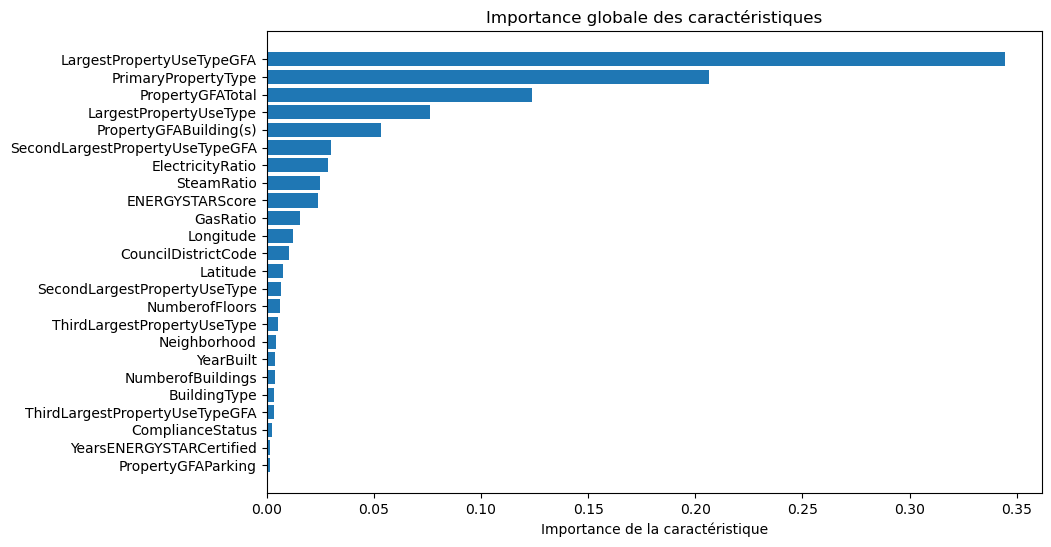

In [98]:
plt.figure(figsize = (10, 6))
plt.barh(range(top_n), feature_importances[indices[:top_n]], align="center")
plt.yticks(range(top_n), sorted_feature_names)
plt.xlabel("Importance de la caractéristique")
plt.title("Importance globale des caractéristiques")
plt.gca().invert_yaxis()
plt.show()

**Commentaires :**
    
- Comme on s'y attendait, les superficies ont un très fort impact dans les prédictions.<br>
- Les types d'utilisation et les ratios énergétiques jouent eux aussi un rôle important.

Il est également possible de regarder la feature importance localement, c'est-à-dire sur chacune des lignes.<br>
On utilise ci-dessous la librairie **shap** pour l'afficher sur chaque ligne d'un échantillon de 300 lignes.

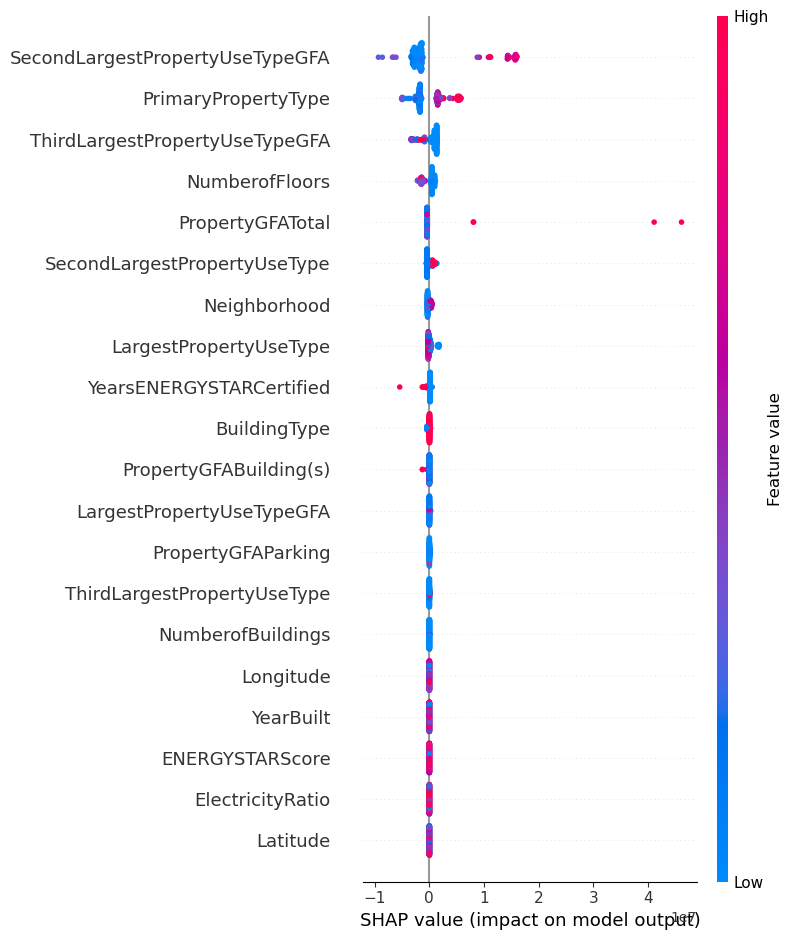

In [99]:
X_train_preprocessed = preprocessor_3.transform(X_train)

feature_names = get_feature_names(preprocessor_3)
cleaned_feature_names = [re.split('__', name, 1)[1] for name in feature_names]

explainer = shap.Explainer(model, X_train_preprocessed)

sample_indices = list(range(300))
shap_values = explainer.shap_values(X_train_preprocessed[sample_indices], check_additivity = False)

shap.summary_plot(shap_values, X_train_preprocessed[sample_indices], feature_names = cleaned_feature_names)

# Construction du modèle final

## Sélection des features

Une dernière étape pour améliorer la performance sur les prédictions est de supprimer les colonnes qui n'ont que très peu d'impact et ne font que générer de la complexité inutile pour les modèles.

On a testé itérativement plusieurs sélections de features en s'appuyant essentiellement sur le feature importance et sur l'analyse exploratoire (corrélation).

In [100]:
zero_filler_features = ['PropertyGFAParking', 'GasRatio', 'ElectricityRatio', 'SteamRatio',
                        'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA']

zero_filler = make_pipeline(SimpleImputer(strategy = "constant", fill_value = 0),
                            RobustScaler())

In [101]:
median_imputer_features = ['PropertyGFATotal', 'PropertyGFABuilding(s)', 'YearBuilt',
                           'Longitude', 'Latitude', 'LargestPropertyUseTypeGFA']

median_imputer = make_pipeline(SimpleImputer(strategy = "median"),
                               RobustScaler())

In [102]:
target_encoder_features = ['Neighborhood', 'PrimaryPropertyType', 'CouncilDistrictCode', 'NumberofFloors', 'NumberofBuildings',
                           'LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']


target_encoder = make_pipeline(SimpleImputer(strategy = "constant", fill_value = "None"),
                               TargetEncoder(),
                               RobustScaler())

In [103]:
preprocessor_4 = ColumnTransformer(transformers = [
    ("median_imputer", median_imputer, median_imputer_features),
    ("zero_filler", zero_filler, zero_filler_features),
    ("target_encoder", target_encoder, target_encoder_features)
])

In [107]:
selected_features = median_imputer_features + zero_filler_features + target_encoder_features

X = df[selected_features].copy()
y = df[target].copy()

cross_evaluate_all(models, preprocessor_4, X, y)

,Time,Score,Fold_1,Fold_2,Fold_3,Fold_4,Fold_5
Model,,,,,,,
Linear Regression,93 ms,0.4361,0.4561,0.3391,0.5572,0.7774,0.0508
Gradient Boost,1129 ms,0.6302,0.4411,0.6194,0.7556,0.7937,0.5415
Random Forest,4790 ms,0.6692,0.5013,0.5918,0.8048,0.8938,0.5543
SVR,204 ms,-0.0677,-0.1848,-0.1108,-0.0001,-0.0001,-0.0427
Elastic Net,58 ms,0.4955,0.3824,0.2617,0.7525,0.7986,0.2824
XGBoost,369 ms,0.4213,0.0976,0.6301,0.3149,0.7398,0.3239
LightGBM,431 ms,0.5986,0.4242,0.5494,0.7597,0.8733,0.3862


In [105]:
cross_evaluate_all(models, preprocessor_4, X, y, log_target = True)

,Time,Score,Fold_1,Fold_2,Fold_3,Fold_4,Fold_5
Model,,,,,,,
Linear Regression,100 ms,-30036.0749,-146504.3539,-3565.8713,-107.1379,0.6092,-3.6207
Gradient Boost,1179 ms,0.5793,0.3993,0.5409,0.6659,0.8363,0.4539
Random Forest,4057 ms,0.5587,0.3565,0.4458,0.8587,0.8831,0.2492
SVR,213 ms,0.0066,-0.0582,0.0116,-0.0713,0.1825,-0.0318
Elastic Net,69 ms,-66.5538,-311.9626,-20.5481,0.6470,0.0614,-0.9667
XGBoost,388 ms,0.5858,0.4646,0.5751,0.8549,0.6887,0.3459
LightGBM,380 ms,0.6610,0.4151,0.5688,0.8478,0.8347,0.6385


Les résultats sont un peu meilleurs avec cette sélection pertinente.<br>
Le passage au logarithme de la cible ne présente toujours pas d'impact significatif.

## Recherche des hyperparamètres

On peut désormais passer à l'étape finale d'amélioration des modèles : la détermination des hyperparamètres optimaux via une grille de recherche.

L'opération est particulièrement coûteuse en temps, c'est pourquoi on l'effectue qu'à la fin et exclusivement pour les modèles les plus prometteurs que sont le Gradient Boost.

In [108]:
def grid_search(model, preprocessor, param_grid, X, y, verbose = 0) :
       
    pipeline = make_pipeline(preprocessor, RobustScaler(), model)
    grid_search = GridSearchCV(estimator = pipeline, param_grid = param_grid, scoring = "r2", cv = 10, verbose = verbose)
    results = grid_search.fit(X, y)

    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
      
    print("\n--- Hyperparamètres ---")
    for (param, value) in best_params.items() :
        print(param, ":", value)
        
    return best_model

In [109]:
selected_features = median_imputer_features + zero_filler_features + target_encoder_features

X = df[selected_features].copy()
y = df[target].copy()

In [110]:
param_grid = {"randomforestregressor__n_estimators" : [200],
              "randomforestregressor__max_features" : [2, 4, 6],
              "randomforestregressor__min_samples_split" : [2, 4, 8],
              "randomforestregressor__bootstrap": [True, False]}

best_model = grid_search(RandomForestRegressor(n_jobs = -1), preprocessor_4, param_grid, X, y, verbose = 1)

Fitting 10 folds for each of 18 candidates, totalling 180 fits

--- Hyperparamètres ---
randomforestregressor__bootstrap : True
randomforestregressor__max_features : 4
randomforestregressor__min_samples_split : 2
randomforestregressor__n_estimators : 200


On peut se permettre d'augmenter le nombre d'estimateurs pour l'entraînement final.<br>
C'est plus coûteux en temps mais c'est généralement bénéfique pour la précision.

In [132]:
pipeline_rf = Pipeline(steps = [
    ("preprocessor", preprocessor_4),
    ("rf", RandomForestRegressor(n_jobs = -1,
                                 bootstrap = False,
                                 max_features = 4,
                                 min_samples_split = 2,
                                 n_estimators = 1000))
])

scores_rg = cross_val_score(pipeline_rf, X, y, cv = 5, scoring = "r2", n_jobs = -1)
print("Random Forest average score :", np.mean(scores_rg))

Random Forest average score : 0.6833871022882267


In [116]:
param_grid = {"gradientboostingregressor__n_estimators" : [50, 100, 200],
              "gradientboostingregressor__learning_rate" : [0.05, 0.1, 0.2],
              "gradientboostingregressor__max_depth" : [3, 4, 5]}

best_model = grid_search(GradientBoostingRegressor(), preprocessor_4 , param_grid, X, y, verbose = 1)

Fitting 10 folds for each of 27 candidates, totalling 270 fits

--- Hyperparamètres ---
gradientboostingregressor__learning_rate : 0.1
gradientboostingregressor__max_depth : 3
gradientboostingregressor__n_estimators : 200


In [145]:
pipeline_gb = Pipeline(steps = [
    ("preprocessor", preprocessor_4),
    ("gb", GradientBoostingRegressor(n_estimators = 1000,
                                      learning_rate = 0.1,
                                      max_depth = 3))
])

scores_gb = cross_val_score(pipeline_gb, df, y, cv = 5, scoring = "r2", n_jobs = -1)
print("Gradient Boost average score :", np.mean(scores_gb))

Gradient Boost average score : 0.6556481871467292


## Conclusion

La recherche d'hyperparamètre a légèrement amélioré les résultats.<br>
Les performances des deux assez proche. La Random Forest semble légèrement meilleure, on va donc la choisir.<br>
Elle est néanmoins plus lente que le Gradient Boost.

In [124]:
best_model = RandomForestRegressor(n_jobs = -1,
                                   bootstrap = False,
                                   max_features = 4,
                                   min_samples_split = 2,
                                   n_estimators = 1000)

Réentraînons ce modèle de Random Forest sur un jeu d'entraînement et évaluons-le sur un jeu de test pour pouvoir recalculer l'importance de chaque feature.

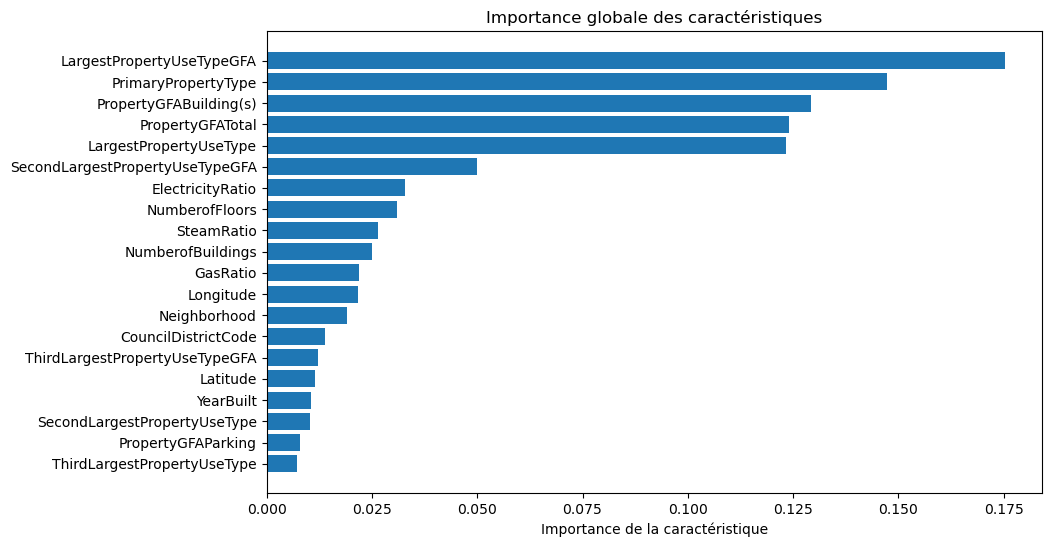

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

pipeline = make_pipeline(preprocessor_4, best_model)
pipeline.fit(X_train, y_train)

feature_importances = best_model.feature_importances_
indices = (-feature_importances).argsort()

feature_names = get_feature_names(preprocessor_4)
cleaned_feature_names = [re.split('__', name, 1)[1] for name in feature_names]
top_n = len(cleaned_feature_names)
sorted_feature_names = [cleaned_feature_names[i] for i in indices[:top_n]]

plt.figure(figsize = (10, 6))
plt.barh(range(top_n), feature_importances[indices[:top_n]], align="center")
plt.yticks(range(top_n), sorted_feature_names)
plt.xlabel("Importance de la caractéristique")
plt.title("Importance globale des caractéristiques")
plt.gca().invert_yaxis()
plt.show()

On retrouve des résultats sensiblement identiques à ceux de la précédente mouture du problème.

Entraînons pour finir le modèle final sur l'intégralité du jeu de données, afin de le préparer au mieux pour la prédiction sur des données futures.

In [127]:
final_pipeline = Pipeline(steps = [
    ("preprocessor", preprocessor_4),
    ("model", best_model)
])

final_pipeline.fit(df, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('median_imputer',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['PropertyGFATotal',
                                                   'PropertyGFABuilding(s)',
                                                   'YearBuilt', 'Longitude',
                                                   'Latitude',
                                                   'LargestPropertyUseTypeGFA']),
                                                 ('zero_filler',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImp...
                                                                                 strategy='constant')),
                                                                  ('targetencoder',
                                                                   TargetEncoder()),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['Neighborhood',
                                                   'PrimaryPropertyType',
                                                   'CouncilDistrictCode',
                                                   'NumberofFloors',
                                                   'NumberofBuildings',
                                                   'LargestPropertyUseType',
                                                   'SecondLargestPropertyUseType',
                                                   'ThirdLargestPropertyUseType'])])),
                ('model',
                 RandomForestRegressor(bootstrap=False, max_features=4,
                                       n_estimators=1000, n_jobs=-1))])